# 餐飲業逾期風險預測模型
由我國「應建立食品追溯追蹤系統之食品業者」規定可知，須申報食品流向資料於本署非追不可系統多為製造與輸入業者，對於販售與餐飲業者則無相關資料可用，無法推算其庫存，進而評估其是否可能存放逾期食品。因此，針對販售與餐飲業者，則透過後市場稽查資料及業者相關資訊，嘗試以監督式學習方法建構業者逾期食品違規風險預測模型，而此處為餐飲業資料的建模評估。

### 程式架構
* 資料前處理(Preprocessing.ipynb)
* 特徵篩選(FeatureSelection.ipynb)
* 資料不平衡處理(HandlingImbData.ipynb)
* **模型配適(ModelFitting.ipynb)**

## 模型配適

### Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data Import

In [2]:
dict_dfs_fs = pd.read_pickle('../data/data_sm.pkl')
print(dict_dfs_fs.keys())

dict_keys(['others', 'train', 'test', 'feature_selection'])


### Data Transform

In [3]:
X_train = dict_dfs_fs['train']['X_select']    # fit transformer
X_smote = dict_dfs_fs['train']['X_smote']
X_test = dict_dfs_fs['test']['X_select']

##### Encoding

In [4]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer

In [5]:
cols_DumEnc = [c for c in X_smote.select_dtypes('category').columns if not X_smote[c].dtypes.ordered]
cols_OrdEnc = [c for c in X_smote.select_dtypes('category').columns if X_smote[c].dtypes.ordered]

trans_enc = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False, dtype='uint8'), cols_DumEnc), 
    (OrdinalEncoder(dtype='uint8'), cols_OrdEnc), 
    remainder='passthrough', 
    force_int_remainder_cols=False, 
    verbose_feature_names_out=False
).set_output(transform='pandas')

# fit
trans_enc.fit(X_train)

# transform
X_train_Enc = trans_enc.transform(X_train)
X_sm_Enc = trans_enc.transform(X_smote)
X_test_Enc = trans_enc.transform(X_test)

##### Standardization

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
# scaler & scaler column names
scaler_stand = StandardScaler().set_output(transform='pandas')
cols_stand = X_smote.select_dtypes(include='float').columns.tolist() + cols_OrdEnc

# fit (use original training set)
scaler_stand.fit(X_train_Enc[cols_stand])

# transform
def scaler_df(df, cols=cols_stand, scaler=scaler_stand): 
    df_scale = scaler.transform(df[cols])
    df_all = pd.concat([df_scale, df.drop(cols, axis=1)], axis=1)
    return df_all

X_sm_EncSca = scaler_df(X_sm_Enc)
X_test_EncSca = scaler_df(X_test_Enc)

In [ ]:
del cols_DumEnc, cols_OrdEnc, cols_stand, trans_enc, scaler_stand, X_train, X_train_Enc, X_smote, X_sm_Enc, X_test, X_test_Enc

### Model Fitting: Logistic Regression (with L1 penalty) 

In [12]:
# from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import ConfusionMatrixDisplay

##### Shuffle

In [13]:
y_smote = dict_dfs_fs['train']['y_smote']
# y_sh, X_sh = shuffle(y_smote, X_sm_EncSca, random_state=27)

In [14]:

def fit_lgs_l1(X, y): 
    mdl = LogisticRegression(penalty='l1', solver='liblinear', max_iter=100, random_state=27)
    mdl.fit(X, y)
    return mdl

lgs_sm = fit_lgs_l1(X_sm_EncSca, y_smote)

### Evaluation

In [16]:
y_test = dict_dfs_fs['test']['y']

In [15]:
# 採用特徵
X_sm_EncSca.columns[lgs_sm.coef_.flatten() > 0]

Index(['資本額', '營業縣市_台南市', '營業縣市_台東縣', '營業縣市_嘉義市', '營業縣市_宜蘭縣', '營業縣市_新竹市',
       '營業縣市_桃園市', '營業縣市_高雄市', '場所型式_c', '投保責任險', '食添法規認知', '逾期食品法規認知',
       '有無技術士證照'],
      dtype='object')

In [17]:
# 預測結果
def result_df(model, X_test, y_test): 
    
    df_rsl = pd.DataFrame(
        {'Actual': y_test.reset_index(drop=True), 
         'PredProb': model.predict_proba(X_test)[:, 1].round(4)}, 
    )

    df_rsl['PredProbRank'] = df_rsl['PredProb'].rank(method='min', ascending=False).astype('uint16')

    return df_rsl

df_rsl = result_df(lgs_sm, X_test_EncSca, y_test)


* ROC

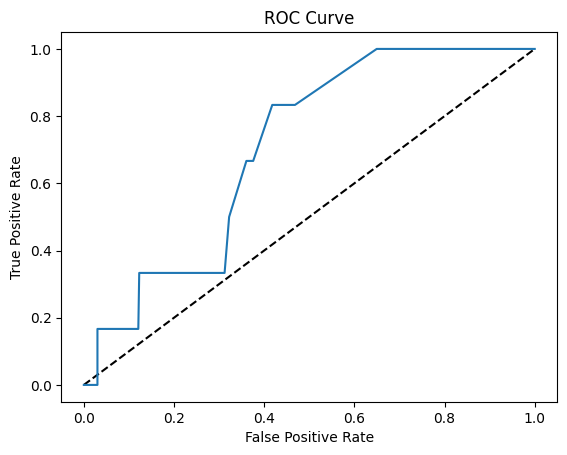

In [18]:
def tprp_rate(actual, pred_prob): 
    
    # true positive rate
    ntp = np.array([((actual == 1) & (pred_prob > thr)).sum() for thr in np.linspace(1, 0, 1001)])
    rtp = ntp / actual.sum()
    
    # false positive rate
    nfp = np.array([((actual == 0) & (pred_prob > thr)).sum() for thr in np.linspace(1, 0, 1001)])
    rfp = nfp / (actual == 0).sum()

    # 補點 (1, 1) ，避免預測機率為 0 情況
    rtp = np.append(rtp, 1.0)
    rfp = np.append(rfp, 1.0)

    return rtp, rfp

rtp_sm, rfp_sm = tprp_rate(actual=df_rsl['Actual'], pred_prob=df_rsl['PredProb'])

plt.plot(np.linspace(0, 1, 3), np.linspace(0, 1, 3), 'k--')
plt.plot(rfp_sm, rtp_sm)

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.show()

* Confusion Matrix

In [ ]:
# 設定閾值為預測機率排序前 200 名
df_rsl['預測排序'] = df_rsl['預測機率'].rank(method='min', ascending=False).astype('uint16')
df_rsl['預測結果_by排序'] = (df_rsl['預測排序'] <= 200).astype('uint8')    # Pandas Vectorization

In [ ]:
# 建立混淆矩陣
tp = df_rsl[(df_rsl['真實值'] == 1) & (df_rsl['預測結果_by排序'] == 1)].shape[0]
fp = df_rsl[(df_rsl['真實值'] == 0) & (df_rsl['預測結果_by排序'] == 1)].shape[0]
fn = df_rsl[(df_rsl['真實值'] == 1) & (df_rsl['預測結果_by排序'] == 0)].shape[0]
tn = df_rsl[(df_rsl['真實值'] == 0) & (df_rsl['預測結果_by排序'] == 0)].shape[0]

# 橫軸 Actual，縱軸 Predicted，左上 True Positive
nda_cm = np.array([[tp, fp], [fn, tn]])
nda_cm

In [ ]:
# Evaluation Metrics
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2 / ((1/precision) + (1/recall))

print(f'precision: {precision: .4f} \nrecall: {recall: .4f} \nf1-score: {f1: .4f}')

In [ ]:
# 繪製混淆矩陣
cm_labels = np.array(['違規', '非違規'])
disp = ConfusionMatrixDisplay(nda_cm, display_labels=cm_labels)

# 設定中文字型（整體）
plt.rcParams['font.family'] = 'Microsoft JhengHei'

# 設定顏色
disp.plot(cmap='Blues')

# 設定軸標題
plt.xlabel("Actual", fontsize=12)
plt.ylabel("Predicted", fontsize=12)

# 設定標題
score_string = f'Precision: {precision: .4f} | Recall: {recall: .4f} | F1-score: {f1: .4f}'
plt.title('Confusion Matrix\n' + score_string)

plt.show()

In [ ]:
# 違規案件預測結果排序
df_rsl = pd.DataFrame(
    {'真實值': y_test, 
     '預測機率': lgs.predict_proba(X_test_ss)[:, 1].round(4), 
     '預測機率(SMOTE)': lgs_sm.predict_proba(X_test_ss)[:, 1].round(4)}
)

i = 0
for id, real, prob1, prob2 in df_rsl.sort_values(by='預測機率', ascending=False).itertuples(): 
    i += 1
    if real: 
        print(f'第{id}筆資料為{real}，預測機率為{prob1}，預測機率(SMOTE)為{prob2}，排序在第{i}位')
